# Step-by-step evaluation of fast vertex substitution

Currently the fast vertex substitution local search gets stuck when $\alpha \ge 2$. The algorithm is going to be interactively evaluated step by step with a small instance to try to catch the bug.

## Initial fixed data

In [1]:
from models.instance import Instance
from models.solver import Solver
from models.vertex import Vertex

In [2]:
users = [
    Vertex(0, 5, 80),
    Vertex(1, 43, 34),
    Vertex(2, 22, 70),
    Vertex(3, 80, 10),
    Vertex(4, 9, 11),
    Vertex(5, 60, 75)
]

facilities = [
    Vertex(0, 30, 50),
    Vertex(1, 81, 61),
    Vertex(2, 11, 21),
    Vertex(3, 55, 25)
]

instance = Instance(users, facilities)

- $n = 6$
- $m = 4$
- $p = 3$
- $\alpha = 1$

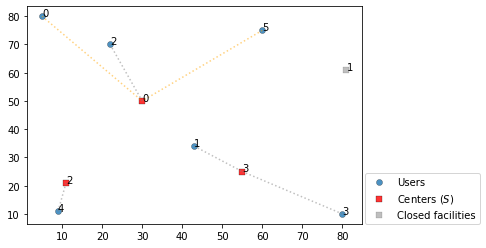

In [3]:
solver = Solver(instance, 3, 1)

solver.solution.open_facilities = {0, 2, 3}
solver.solution.closed_facilities = {1}
solver.allocate_all()
solver.update_obj_func()

solver.plot()

The objective function value, $x$, is:

In [4]:
solver.solution.get_objective_function()

39

The critical allocation determines $x$:

In [5]:
solver.solution.critical_allocation

AllocatedFacility(index=0, user=0, distance=39)

In this case there are two allocations that are the largest distance. For demonstration purposes, let's manually change the critical allocation:

In [6]:
from models.allocated_facility import AllocatedFacility

solver.solution.critical_allocation = AllocatedFacility(0, 5, 39)
solver.solution.critical_allocation

AllocatedFacility(index=0, user=5, distance=39)

The critical facility $f_*$ is $0$ and the critical user $u_*$ is $5$, and their distance is $x = 39$.

## The algorithm

### Iteration 1

In [7]:
import sys

best_obj_func = sys.maxsize
best_in = -1
best_out = -1

#### Loop closed facilities

In [8]:
solver.solution.closed_facilities

{1}

If facility $1$ is inserted, $f_i = 1$, its distance to $u_*$ would be

In [9]:
fi_distance = solver.instance.get_distance(5, 1)
fi_distance

25

which is less than $x$, $25 < 39$. This means the $x$ can be broken and find a better value, so $f_i$ remains as $1$.

Now let's evaluate `move()`.

##### Find a facility to close or remove from the solution, $f_r$, when $f_i = 1$.

In [10]:
current_of = 0
r = {0:0, 2:0, 3:0}
z = {0:0, 2:0, 3:0}

###### Loop users

In [11]:
solver.instance.users_indexes

{0, 1, 2, 3, 4, 5}

$u = 0$

In [12]:
u_fi_dist = solver.instance.get_distance(0, 1)
u_fi_dist

78

In [13]:
closests = solver.get_alpha_range_closests(0)
closests

{1: AllocatedFacility(index=0, user=0, distance=39),
 2: AllocatedFacility(index=2, user=0, distance=59)}

The $\alpha$-th (in this case the very first, $\alpha = 1$ thus PCP) closest facility of $u$ is index $0$, $f_\alpha(u) = 0$.

$f_i$ is not closer to $u$ than $f_\alpha$:

$d_i > d_\alpha \rightarrow 78 > 39$

So data structures $r$ and $z$ need to be updated by "deleting" $f_\alpha = 0$.

- $r(f_\alpha) \leftarrow \max\{ r(f_\alpha), d_\alpha \}$
- $r(0) \leftarrow \max\{ r(0), d_0 \}$

In [14]:
r[0]

0

In [15]:
closests[1].distance

39

- $r(0) \leftarrow \max\{ 0, 39 \}$

In [16]:
r[0] = 39

- $z(f_\alpha) \leftarrow \max\{ z(f_\alpha), \min\{ d_i, d_{\alpha + 1} \} \}$
- $z(0) \leftarrow \max\{ z(0), \min\{ d_i, d_{2} \} \}$

In [17]:
z[0]

0

In [18]:
u_fi_dist

78

In [19]:
closests[2].distance

59

- $z(0) \leftarrow \max\{ 0, \min\{ 78, 59 \} \}$

In [20]:
min(78, 59)

59

- $z(0) \leftarrow \max\{ 0, 59 \}$

In [21]:
z[0] = 59

Next user $u = 1$

In [ ]:
u_fi_dist = solver.instance.get_distance(1, 1)
u_fi_dist

47

In [22]:
closests = solver.get_alpha_range_closests(1)
closests

{2: AllocatedFacility(index=0, user=1, distance=21),
 1: AllocatedFacility(index=3, user=1, distance=15)}

In [23]:
closests[1]

AllocatedFacility(index=3, user=1, distance=15)

$f_\alpha = 3$, $d_\alpha = 15$

$d_i > d_\alpha$ so update $r$ and $z$.

In [24]:
r[3]

0

In [25]:
r[3] = 15

In [26]:
z[3]

0

In [27]:
min(47, 21)

21

In [28]:
z[3] = 21

Next user $u = 2$.

In [ ]:
u_fi_dist = solver.instance.get_distance(2, 1)
u_fi_dist

60

In [29]:
closests = solver.get_alpha_range_closests(2)
closests

{1: AllocatedFacility(index=0, user=2, distance=22),
 2: AllocatedFacility(index=2, user=2, distance=50)}

$60 > 22$ so update $r$ and $z$.

In [30]:
r[0]

39

In [31]:
max(39, 22)

39

$r(0)$ doesn't change.

In [32]:
z[0]

59

In [33]:
min(60, 50)

50

In [34]:
max(59, 50)

59

$z(0)$ doesn't change either.

Next user $u = 3$

In [ ]:
u_fi_dist = solver.instance.get_distance(3, 1)
u_fi_dist

51

In [35]:
closests = solver.get_alpha_range_closests(3)
closests

{2: AllocatedFacility(index=0, user=3, distance=64),
 1: AllocatedFacility(index=3, user=3, distance=29)}

$51 > 29$ so update $r$ and $z$:

In [37]:
r[3]

15

In [38]:
max(15, 29)

29

In [39]:
r[3] = 29

In [40]:
z[3]

21

In [41]:
min(51, 64)

51

In [42]:
max(21, 51)

51

In [43]:
z[3] = 51

Next user $u = 4$

In [44]:
u_fi_dist = solver.instance.get_distance(4, 1)
u_fi_dist

88

In [45]:
closests = solver.get_alpha_range_closests(4)
closests

{2: AllocatedFacility(index=0, user=4, distance=44),
 1: AllocatedFacility(index=2, user=4, distance=10)}

$88 > 10$ so update $r$ and $z$.

In [46]:
r[2]

0

In [47]:
r[2] = 10

In [48]:
z[2]

0

In [49]:
min(88, 44)

44

In [50]:
z[2] = 44

Next user $u = 5$

In [ ]:
u_fi_dist = solver.instance.get_distance(5, 1)
u_fi_dist

25

In [51]:
closests = solver.get_alpha_range_closests(5)
closests

{1: AllocatedFacility(index=0, user=5, distance=39),
 2: AllocatedFacility(index=3, user=5, distance=50)}

This $u$ is $u_*$. This is the case that breaks $x$, the reason to enter this current loop, because $d_\alpha(u) = 39$ is $x$, and $d_i = 25$ is less than that.

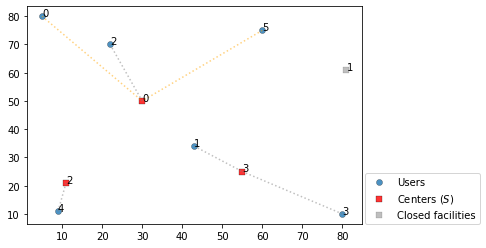

In [52]:
solver.plot()

So update the current objective function $x'$:

- $x' \leftarrow \max\{ x', d_i \}$

In [53]:
current_of

0

- $x' \leftarrow \max\{ 0, 25 \}$

In [54]:
current_of = 25

Due to $d_i < d_\alpha$, data structures $r$ and $z$ don't get updated.

###### Find best deletion

All users were compared, let's check the data structures:

In [55]:
current_of

25

In [56]:
r

{0: 39, 2: 10, 3: 29}

In [57]:
z

{0: 59, 2: 44, 3: 51}

The largest distance, $g_1$, and the second largest distance, $g_2$, from $r$ are:

In [58]:
from models.moved_facility import MovedFacility

g1 = MovedFacility(0, 39)
g2 = MovedFacility(3, 29)

Let $j_*$ be the corresponding index of $g_1$: $j_* = 0$.

Find $f_r$:

$$f_r = \min_{j \in S}\{ \max\{ x', z(j), \max_{l \neq j}{r(l)} \} \}$$

Loop open facilities in the solution, $S$, which are also the indexes or keys of $z$ and $r$:

In [59]:
solver.solution.open_facilities

{0, 2, 3}

For $j = 0$, $l \in \{ 2, 3 \}$:

In [60]:
max(10, 29)

29

$r(l) = 29$:

In [61]:
max(25, 59, 29)

59

Now there's a better $f_r = j = 0$ with $x_* = 59$.

In [ ]:
fr = MovedFacility(0, 59)

For $j = 2$, $l \in \{0, 3\} $

In [62]:
max(39, 29)

39

In [63]:
max(25, 44, 39)

44

$44 < 59$ so $x_*$ is improved and now $f_r = 2$.

In [64]:
fr = MovedFacility(2, 44)

For $j = 3$, $l \in \{0, 2\}$

In [65]:
max(39, 10)

39

In [66]:
max(25, 51, 39)

51

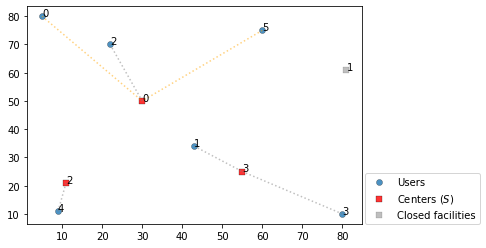

In [67]:
solver.plot()

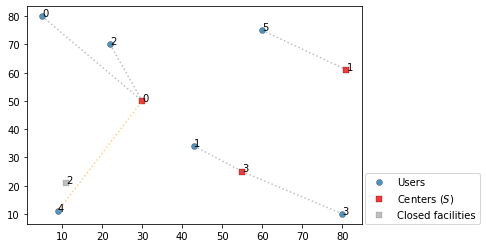

Solution(open_facilities={0, 1, 3}, critical_allocation=AllocatedFacility(index=0, user=4, distance=44))

In [68]:
solver.swap(1, 2)
solver.plot()
solver.solution

We can see that indeed the objective function value after the swap is $44$, the value of $x_*$, meaning that the data structures $r$ and $z$ are consistent with the values they store.

This solution though is worse than the other one whose objective function was $39$, so in an iteration this swap wouldn't have been applied.